In [1]:
import os, random, time
import xgboost
import datetime
import pygam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from fbprophet import Prophet
from sklearn.linear_model import LinearRegression as LR
from sklearn.kernel_ridge import KernelRidge as KR
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, Lars, Lasso
from sklearn.ensemble import RandomForestRegressor as RF

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel as C, RBF

In [2]:
y_inven = pd.read_csv('./E61D_Inven.csv')
x_sales = pd.read_csv('./E61D_Sale.csv')
x_product = pd.read_csv('./E61D_Product.csv')
d_set = pd.merge(pd.merge(y_inven, x_sales, how='left', on='Week'), x_product, how='left', on='Week')
d_set = d_set.drop(columns=['5xxx', '3xxC', '3xxT'])
d_set[d_set < -1000] = 0
#d_set_log = d_set.copy()
#d_set_log[d_set < 0] = 0
#d_set.to_csv('data_0506.csv', index=False)

rm_week = [201952, 202001, 202052, 202053, 202101]
rm_index = [i for i,s in enumerate(d_set['Week']) if s not in rm_week]
d_set1 = d_set.loc[rm_index]
d_set1 = d_set1.reset_index(drop=True)

#d_set1.to_csv('data_0506.csv', index=False)
print(d_set1.shape)

(114, 84)


In [210]:
inven_col = [s for s in d_set1.columns if 'Prev_Inven' in s]
sale_col = [s for s in d_set1.columns if 'Sale' in s]
product_col = [s for s in d_set1.columns if 'Product' in s]
y_col = [s for s in d_set1.columns if 'Inven' == s]

In [212]:
d_set1[list(y_col+product_col)].corr(method='pearson').iloc[0,:] #product_col+sale_col+inven_col

Inven              1.000000
Product            0.329589
Var_Product_1      0.417965
Var_Product_2      0.525300
Var_Product_3      0.526365
Var_Product_4      0.535936
Var_Product_5      0.553193
Var_Product_6      0.549045
Var_Product_7      0.376513
Var_Product_8      0.489986
Var_Product_9      0.523144
Var_Product_10     0.448480
Var_Product_11     0.409971
Var_Product_12     0.479421
Post_Product_1     0.435525
Post_Product_2     0.430532
Post_Product_3     0.345714
Post_Product_4     0.246834
Post_Product_5     0.166354
Post_Product_6     0.088246
Post_Product_7    -0.054379
Post_Product_8    -0.056076
Post_Product_9     0.011674
Post_Product_10   -0.009371
Post_Product_11   -0.023078
Post_Product_12   -0.039074
Prev_Product_1     0.330158
Prev_Product_2     0.346040
Prev_Product_3     0.338050
Prev_Product_4     0.358061
Prev_Product_5     0.345569
Prev_Product_6     0.329170
Prev_Product_7     0.228248
Prev_Product_8     0.105572
Prev_Product_9    -0.040886
Prev_Product_10   -0

'\nplt.subplot(3,2,2)\nplt.title("Log(Sales)")\nplt.plot(np.log(d_set1[\'Sale\']), color=\'blue\', marker=\'o\')\nplt.subplot(3,2,4)\nplt.title("Log(Products)")\nplt.plot(np.log(d_set1[\'Product\']), color=\'red\', marker=\'o\')\nplt.subplot(3,2,6)\nplt.title("Log(Inventory)")\nplt.plot(np.log(d_set1[\'Inven\']), color=\'red\', marker=\'o\')\n'

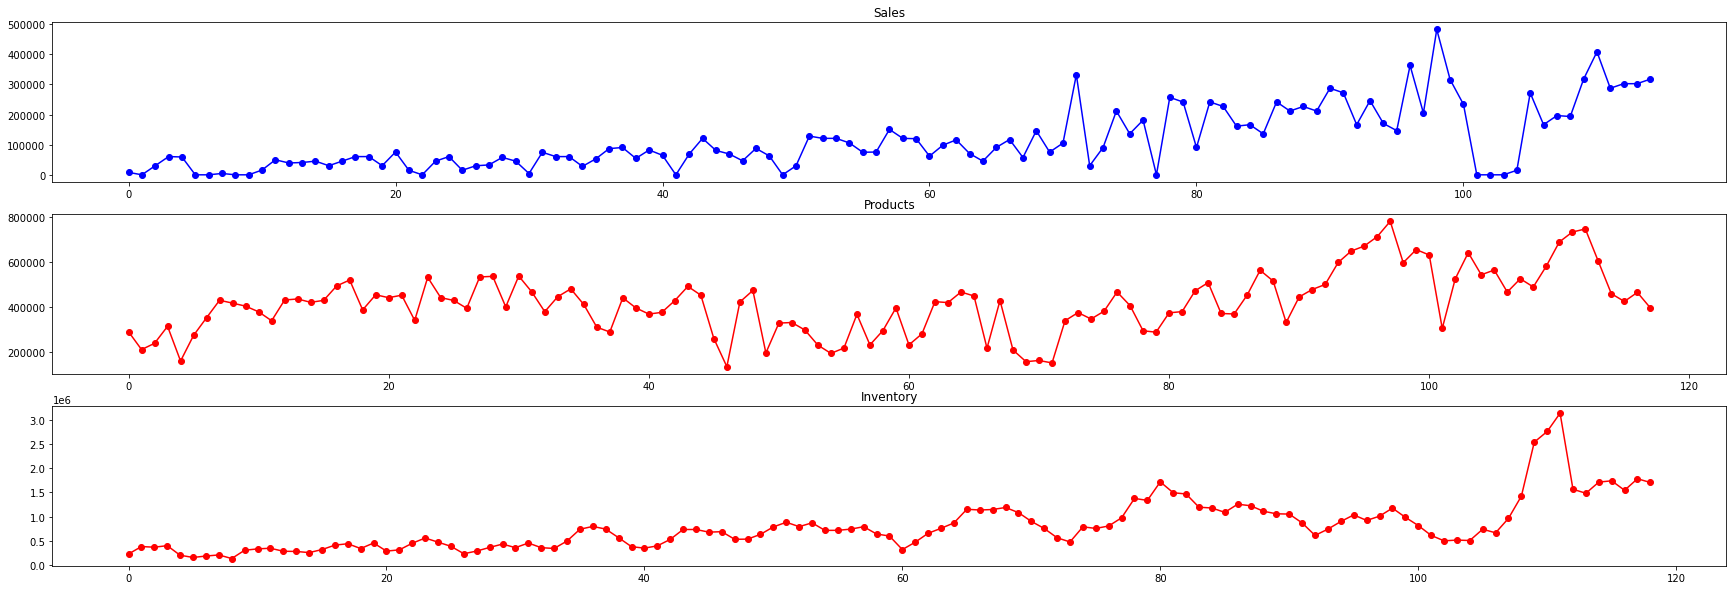

In [193]:
plt.figure(figsize=(30,10))
plt.subplot(3,1,1)
plt.title("Sales")
plt.plot((d_set['Sale']), color='blue', marker='o')
plt.subplot(3,1,2)
plt.title("Products")
plt.plot((d_set['Product']), color='red', marker='o')
plt.subplot(3,1,3)
plt.title("Inventory")
plt.plot((d_set['Inven']), color='red', marker='o')
'''
plt.subplot(3,2,2)
plt.title("Log(Sales)")
plt.plot(np.log(d_set1['Sale']), color='blue', marker='o')
plt.subplot(3,2,4)
plt.title("Log(Products)")
plt.plot(np.log(d_set1['Product']), color='red', marker='o')
plt.subplot(3,2,6)
plt.title("Log(Inventory)")
plt.plot(np.log(d_set1['Inven']), color='red', marker='o')
'''

In [167]:
def run_model_1(m_, x_dta, wt_mat, t_col_k, s_col_k, p_col_k, tr_s_day, tr_e_day, te_s_day=None, te_e_day=None):    
    tr_time = np.array([tr_s_day, tr_e_day])
    te_time = np.array([te_s_day, te_e_day])
    s_ind, e_ind = np.where(tr_time[0] == x_dta['Week'])[0][0], np.where(tr_time[1] == x_dta['Week'])[0][0]
    te_s_ind, te_e_ind = np.where(te_time[0] == x_dta['Week'])[0][0], np.where(te_time[1] == x_dta['Week'])[0][0]

    target_col = [s for s in x_dta.columns.values if 'Inven' == s]
    week_col = [s for s in x_dta.columns.values if 'Week' in s]

    prev_target_col = [s for s in x_dta.columns.values if 'Prev_Inven' in s]
    var_sale_col = [s for s in x_dta.columns.values if 'Var_Sale' in s]
    var_product_col = [s for s in x_dta.columns.values if 'Var_Product' in s]
    sale_col = [s for s in x_dta.columns.values if 'Sale' == s]
    product_col = [s for s in x_dta.columns.values if 'Product' == s]

    tmp_x_set1, tmp_x_set2, tmp_x_set3 = x_dta[prev_target_col], x_dta[var_sale_col], x_dta[var_product_col]    
    tmp_x_set1 = np.multiply(tmp_x_set1, np.tile([wt_mat[:tmp_x_set1.shape[1]]], tmp_x_set1.shape[0]).reshape(tmp_x_set1.shape[0], -1)).copy()
    tmp_x_set2 = np.multiply(tmp_x_set2, np.tile([wt_mat], tmp_x_set2.shape[0]).reshape(tmp_x_set2.shape[0], -1)).copy()
    tmp_x_set3 = np.multiply(tmp_x_set3, np.tile([wt_mat], tmp_x_set3.shape[0]).reshape(tmp_x_set3.shape[0], -1)).copy()

    tmp_x_set1_re = tmp_x_set1.iloc[:,:t_col_k]
    tmp_x_set2_re = tmp_x_set2.iloc[:,:s_col_k]
    tmp_x_set3_re = tmp_x_set3.iloc[:,:p_col_k]

    x_dta_re = pd.concat([x_dta[list(week_col+target_col+sale_col+product_col)], tmp_x_set1_re, tmp_x_set2_re, tmp_x_set3_re], axis=1)

    train_set = x_dta_re.iloc[s_ind:e_ind, :]
    test_set = x_dta_re.iloc[te_s_ind:(te_e_ind+1), :]#.copy()

    tr_x_set = train_set[list(prev_target_col[:t_col_k]+sale_col+var_sale_col[:s_col_k]+product_col+var_product_col[:p_col_k])]
    tr_y_set = np.array(train_set[target_col]).reshape(-1,1)
    te_x_set = test_set[list(prev_target_col[:t_col_k]+sale_col+var_sale_col[:s_col_k]+product_col+var_product_col[:p_col_k])]
    te_y_set = np.array(test_set[target_col]).reshape(-1,1)


    m_.fit(tr_x_set, tr_y_set)
    hat_prev_ = m_.predict(tr_x_set)
    if len(np.shape(hat_prev_)) == 1:
        hat_prev_ = hat_prev_.reshape(-1,1)

    real_ = np.mean(np.ones_like(tr_y_set) - np.clip(np.abs(tr_y_set - hat_prev_) / tr_y_set , 0, 1)) * 100   

    hat_ = []
    prev_x = list(map(lambda j : x_dta_re['Inven'].iloc[te_s_ind-j], range(1, t_col_k+1)))
    for i in range(0, te_x_set.shape[0]):    
        var_x = te_x_set[list(sale_col+var_sale_col[:s_col_k]+product_col+var_product_col[:p_col_k])].iloc[i,:]
        te_x_ = np.array(prev_x+list(var_x)).reshape(1,-1)    
        tmp_y_hat_ = m_.predict(te_x_)
        if len(np.shape(tmp_y_hat_)) > 1:
            tmp_y_hat_ = tmp_y_hat_.reshape(-1, )            
        prev_x = (list(tmp_y_hat_) + prev_x)[:t_col_k]
#            if len(np.shape(tmp_y_hat_)) == 1:
#                tmp_y_hat_ = tmp_y_hat_.reshape(-1,1)        
        hat_.append(tmp_y_hat_)
    Y_hat_ = np.concatenate((hat_prev_, hat_)) #hat_))#    
    Y_     = np.concatenate((tr_y_set, te_y_set))
    fcst_ = np.mean(np.ones_like(te_y_set) - np.clip(np.abs(te_y_set - hat_[0]) / te_y_set , 0, 1)) * 100    
    return real_, fcst_, Y_, Y_hat_, hat_prev_, hat_

In [181]:
def run_model_2(m_, x_dta, target_key, wt_mat, tr_s_day, tr_e_day, te_s_day=None, te_e_day=None, col_k=None, col_k1=None):    
    
    tr_time = np.array([tr_s_day, tr_e_day])
    te_time = np.array([te_s_day, te_e_day])
    s_ind, e_ind = np.where(tr_time[0] == x_dta['Week'])[0][0], np.where(tr_time[1] == x_dta['Week'])[0][0]
    te_s_ind, te_e_ind = np.where(te_time[0] == x_dta['Week'])[0][0], np.where(te_time[1] == x_dta['Week'])[0][0]

    target_col = [s for s in x_dta.columns.values if target_key == s]    
    tmp_x_col = [s for s in x_dta.columns.values if 'Prev_'+target_key in s]
    tmp_x_col1 = [s for s in x_dta.columns.values if 'Var_'+target_key in s]
    week_col = [s for s in x_dta.columns.values if 'Week' in s]

    tmp_x_set1, tmp_x_set2 = x_dta[tmp_x_col], x_dta[tmp_x_col1]
    tmp_x_set1 = np.multiply(tmp_x_set1, np.tile([wt_mat], tmp_x_set1.shape[0]).reshape(tmp_x_set1.shape[0], -1)).copy()
    tmp_x_set2 = np.multiply(tmp_x_set2, np.tile([wt_mat], tmp_x_set2.shape[0]).reshape(tmp_x_set2.shape[0], -1)).copy()

    if target_key == 'Product':
        tmp_x_set1_re = tmp_x_set1.iloc[:,:col_k]
        tmp_x_set2_re = tmp_x_set2.iloc[:,:col_k1]
        x_dta_re = pd.concat([x_dta[list(week_col+target_col)], tmp_x_set1_re, tmp_x_set2_re], axis=1)
        train_col = list(tmp_x_col[:col_k]+tmp_x_col1[:col_k1])    
    elif target_key == 'Sale':
        tmp_x_set2_re = tmp_x_set2.iloc[:,:col_k1]
        x_dta_re = pd.concat([x_dta[list(week_col+target_col)], tmp_x_set2_re], axis=1)
        train_col = list(tmp_x_col1[:col_k1])


    train_set = x_dta_re.iloc[s_ind:e_ind, :]
    test_set = x_dta_re.iloc[te_s_ind:te_e_ind, :]#.copy()

    tr_x_set = train_set[train_col]
    tr_y_set = np.array(train_set[target_col]).reshape(-1,1)
    te_x_set = test_set[train_col]
    te_y_set = np.array(test_set[target_col]).reshape(-1,1)

    m_.fit(tr_x_set, tr_y_set)
    hat_prev_ = m_.predict(tr_x_set)
    if len(np.shape(hat_prev_)) == 1:
        hat_prev_ = hat_prev_.reshape(-1,1)

    real_ = np.mean(np.ones_like(tr_y_set) - np.clip(np.abs(tr_y_set - hat_prev_) / tr_y_set , 0, 1)) * 100    
    #if len(tr_y_set) > 0 :
    #    tmp_y_id_ = np.where(tr_y_set!=0)[0]
    #    real_ = np.mean(1- np.abs(tr_y_set[tmp_y_id_] - hat_prev_[tmp_y_id_]) / np.abs(tr_y_set[tmp_y_id_])) * 100
    #else:
    #    real_ = np.mean(1- np.abs(tr_y_set - hat_prev_) / np.abs(tr_y_set)) * 100     

    hat_ = []
    if target_key == 'Product':
        prev_x = list(map(lambda j : x_dta_re[target_key].iloc[te_s_ind-j], range(1, col_k+1)))
        for i in range(te_s_ind, te_e_ind+1):    
            var_x = x_dta_re[tmp_x_col1[:col_k1]].iloc[i]        
            te_x_ = np.array(prev_x+list(var_x)).reshape(1,-1)    
            #print(te_x_.shape)
            tmp_y_hat_ = m_.predict(te_x_)
            if len(np.shape(tmp_y_hat_)) > 1:
                tmp_y_hat_ = tmp_y_hat_.reshape(-1, )            
            prev_x = (list(tmp_y_hat_) + prev_x)[:col_k]
#            if len(np.shape(tmp_y_hat_)) == 1:
#                tmp_y_hat_ = tmp_y_hat_.reshape(-1,1)        
            hat_.append(tmp_y_hat_)
        Y_hat_ = np.concatenate((hat_prev_, hat_)) #hat_))#
            
    elif target_key == 'Sale':
        tmp_y_hat_ = m_.predict(te_x_set)
        if len(np.shape(tmp_y_hat_)) == 1:
            tmp_y_hat_ = tmp_y_hat_.reshape(-1,1)    
        hat_.append(tmp_y_hat_) 
        Y_hat_ = np.concatenate((hat_prev_, hat_[0])) #hat_))#

    
    Y_     = np.concatenate((tr_y_set, te_y_set))
    fcst_ = np.mean(np.ones_like(te_y_set) - np.clip(np.abs(te_y_set - hat_[0]) / te_y_set , 0, 1)) * 100    
    return real_, fcst_, Y_, Y_hat_, hat_prev_, hat_[0]

In [162]:
#####    |  78.24    |  0.9153   |  11.54    |  2.18     |  0.4227   |  8.747    |  57.98    |  0.7459   |  => Sale / Var
#####    |  target   |   alpha   |   col_k   |  col_k1   |   m_lr    | m_max_... | m_n_es... | m_subs... |
#####    |  89.51    |  0.9372   |  2.36     |  1.64     |  0.486    |  6.004    |  18.09    |  0.5309   |  =>  Product / Var & Prev


x_dta = d_set1
tr_s_day, tr_e_day = 201945, 202102
te_s_day, te_e_day = 202102, 202112
target_key = 'Sale'
p_alpha = round(0.9084, 3)
col_k, col_k1 = None, round(6.8) #round(5.68)
p_lr=round(0.301,2)
p_max = round(6.29)
p_est = round(93.36)
p_sub = round(0.8594,2)
wt_mat = list(map(lambda x : p_alpha**x if x > 0 else 1, range(0,12)))    #    

#m_=xgboost.XGBRegressor(n_estimators=p_est, learning_rate=p_lr, subsample=p_sub, max_depth=p_max, tree_method='gpu_hist', gpu_id=0)
m_ = KR(0.23)
  
tr_time = np.array([tr_s_day, tr_e_day])
te_time = np.array([te_s_day, te_e_day])
s_ind, e_ind = np.where(tr_time[0] == x_dta['Week'])[0][0], np.where(tr_time[1] == x_dta['Week'])[0][0]
te_s_ind, te_e_ind = np.where(te_time[0] == x_dta['Week'])[0][0], np.where(te_time[1] == x_dta['Week'])[0][0]
print(te_s_ind, te_e_ind, s_ind, e_ind)

target_col = [s for s in x_dta.columns.values if target_key == s]    
tmp_x_col = [s for s in x_dta.columns.values if 'Prev_'+target_key in s]
tmp_x_col1 = [s for s in x_dta.columns.values if 'Var_'+target_key in s]
week_col = [s for s in x_dta.columns.values if 'Week' in s]

tmp_x_set1, tmp_x_set2 = x_dta[tmp_x_col], x_dta[tmp_x_col1]
tmp_x_set1 = np.multiply(tmp_x_set1, np.tile([wt_mat], tmp_x_set1.shape[0]).reshape(tmp_x_set1.shape[0], -1)).copy()
tmp_x_set2 = np.multiply(tmp_x_set2, np.tile([wt_mat], tmp_x_set2.shape[0]).reshape(tmp_x_set2.shape[0], -1)).copy()

if target_key == 'Product':
    tmp_x_set1_re = tmp_x_set1.iloc[:,:col_k]
    tmp_x_set2_re = tmp_x_set2.iloc[:,:col_k1]
    x_dta_re = pd.concat([x_dta[list(week_col+target_col)], tmp_x_set1_re, tmp_x_set2_re], axis=1)
    train_col = list(tmp_x_col[:col_k]+tmp_x_col1[:col_k1])    
elif target_key == 'Sale':
    tmp_x_set2_re = tmp_x_set2.iloc[:,:col_k1]
    x_dta_re = pd.concat([x_dta[list(week_col+target_col)], tmp_x_set2_re], axis=1)
    train_col = list(tmp_x_col1[:col_k1])
    

train_set = x_dta_re.iloc[s_ind:e_ind, :]
test_set = x_dta_re.iloc[te_s_ind:(te_e_ind+1), :]#.copy()

tr_x_set = train_set[train_col]
tr_y_set = np.array(train_set[target_col]).reshape(-1,1)
te_x_set = test_set[train_col]
te_y_set = np.array(test_set[target_col]).reshape(-1,1)

m_.fit(tr_x_set, tr_y_set)
hat_prev_ = m_.predict(tr_x_set)
if len(np.shape(hat_prev_)) == 1:
    hat_prev_ = hat_prev_.reshape(-1,1)
real_ =  np.mean(np.ones_like(tr_y_set) - np.clip(np.abs(tr_y_set - hat_prev_) / tr_y_set , 0, 1)) * 100    


hat_ = []
if target_key == 'Product':
    prev_x = list(map(lambda j : x_dta_re[target_key].iloc[te_s_ind-j], range(1, col_k+1)))
    for i in range(te_s_ind, te_e_ind+1):    
        var_x = x_dta_re[tmp_x_col1[:col_k1]].iloc[i]        
        te_x_ = np.array(prev_x+list(var_x)).reshape(1,-1)    
        #print(te_x_.shape)
        tmp_y_hat_ = m_.predict(te_x_)
        if len(np.shape(tmp_y_hat_)) > 1:
            tmp_y_hat_ = tmp_y_hat_.reshape(-1, )            
        prev_x = (list(tmp_y_hat_) + prev_x)[:col_k]
#            if len(np.shape(tmp_y_hat_)) == 1:
#                tmp_y_hat_ = tmp_y_hat_.reshape(-1,1)        
        hat_.append(tmp_y_hat_)
    Y_hat_ = np.concatenate((hat_prev_, hat_)) #hat_))#

elif target_key == 'Sale':
    tmp_y_hat_ = m_.predict(te_x_set)
    print(tmp_y_hat_.shape)
    if len(np.shape(tmp_y_hat_)) == 1:
        tmp_y_hat_ = tmp_y_hat_.reshape(-1, 1)             
    print(tmp_y_hat_.shape)
    hat_.append(tmp_y_hat_) 
    Y_hat_ = np.concatenate((hat_prev_, hat_[0])) #hat_))#

Y_     = np.concatenate((tr_y_set, te_y_set))
fcst_ = np.mean(np.ones_like(te_y_set) - np.clip(np.abs(te_y_set - hat_[0]) / te_y_set , 0, 1)) * 100   

99 109 42 99
(11, 1)
(11, 1)


/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide


In [157]:
np.shape(hat_)

(1, 11, 1)

0.85 75 0.01 0.43 8 None 8
69.20442258114385 72.47414530824848
(67, 1) (67, 1) (57, 1) (10, 1)


/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


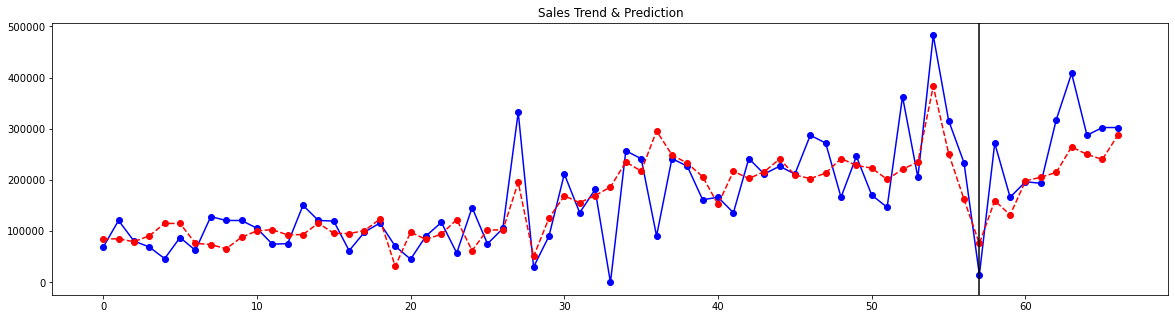

In [182]:
#####################################################################################################################
#####    |  target   |   alpha   |   col_k   |  col_k1   |   m_lr    | m_max_... | m_n_es... | m_subs... |
#####    |  78.24    |  0.9153   |  11.54    |  2.18     |  0.4227   |  8.747    |  57.98    |  0.7459   |  => Kernel_Ridge : Var_sale
#####    |  78.24    |  0.9153   |  11.54    |  2.18     |  0.4227   |  8.747    |  57.98    |  0.7459   |  => Sale / Var

p_alpha = round(0.85, 3)
p_col1, p_col2 = None, round(8.361)
p_lr=round(0.01,2)
p_max = round(7.76)
p_est = round(74.95)
p_sub = round(0.4331,2)
print(p_alpha, p_est, p_lr, p_sub, p_max, p_col1, p_col2)    

weight_mat = list(map(lambda x : p_alpha**x if x > 0 else 1, range(0,12)))    
#model_=xgboost.XGBRegressor(n_estimators=p_est, learning_rate=p_lr, subsample=p_sub, max_depth=p_max, tree_method='gpu_hist', gpu_id=0)
model_ = KR(p_lr)
sale_acc_, sale_acc_hat_, sale_, sale_hat_, sale_test_, sale_test_hat_  = run_model_2(model_, d_set1, 'Sale', weight_mat, 201945, 202102, 202102, 202112, p_col1, p_col2)

plt.figure(figsize=(20,5))
plt.title("Sales Trend & Prediction")
print(sale_acc_, sale_acc_hat_)
print(sale_.shape, sale_hat_.shape, sale_test_.shape, sale_test_hat_.shape)
plt.plot(sale_, color='blue', marker='o')
plt.plot(sale_hat_, color='red', linestyle='dashed', marker='o')
plt.axvline(len(sale_test_), c='k')

99 109 42 99
75.74589141526604 81.71598878528332
(67, 1) (68, 1) (57, 1) (1,)


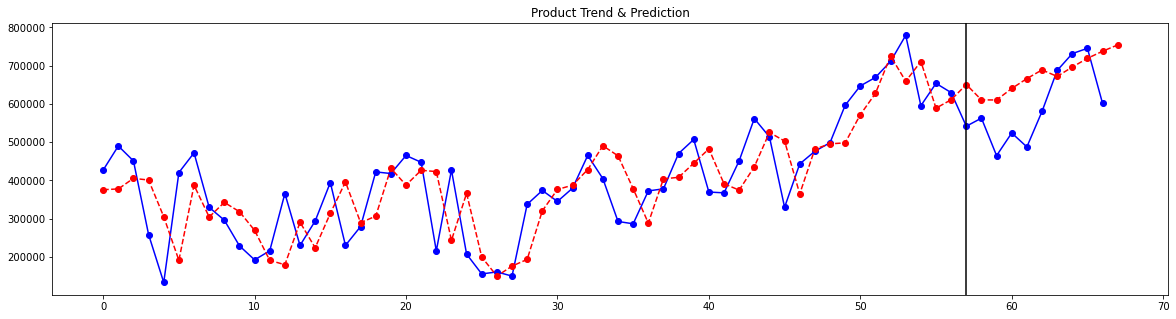

In [180]:
#####################################################################################################################
#####    |  target   |   alpha   |   col_k   |  col_k1   |   m_lr    | m_max_... | m_n_es... | m_subs... |
#####    |  89.51    |  0.9372   |  2.36     |  1.64     |  0.486    |  6.004    |  18.09    |  0.5309   |  =>  Product / Var & Prev
#####    |  73.91    |  0.9197   |  10.75    |  3.53     |  0.4419   |  4.082    |  57.18    |  0.5262   |
#####    |  91.75    |  0.9139   |  1.232    |  9.146    |  0.1137   |  4.593    |  54.24    |  0.4267   |

p_alpha = round(0.9851, 3)
p_lr=round(0.1873,2)
p_col1, p_col2 = round(1.796), round(1.627)
p_max = round(4.593)
p_est = round(54.24)
p_sub = round(0.4267,2)
    
weight_mat = list(map(lambda x : p_alpha**x if x > 0 else 1, range(0,12)))    
#model_=xgboost.XGBRegressor(n_estimators=p_est, learning_rate=p_lr, subsample=p_sub, max_depth=p_max, tree_method='gpu_hist', gpu_id=0)
model_ = KR(p_lr)
product_acc_, product_acc_hat_, product_, product_hat_, product_test_, product_test_hat_ = run_model_2(model_, d_set1, 'Product', weight_mat, 201945, 202102, 202102, 202112, p_col1, p_col2)
plt.figure(figsize=(20,5))
plt.title("Product Trend & Prediction")

print(product_acc_, product_acc_hat_)
print(product_.shape, product_hat_.shape, product_test_.shape, product_test_hat_.shape)

plt.plot(product_, color='blue', marker='o')
plt.plot(product_hat_, color='red', linestyle='dashed', marker='o')
plt.axvline(len(product_test_), c='k')

In [175]:
print(d_set1.shape)
print(product_hat_.shape)


(114, 84)
(68, 1)
(67, 1)


89.96957990926462 29.129253460390707


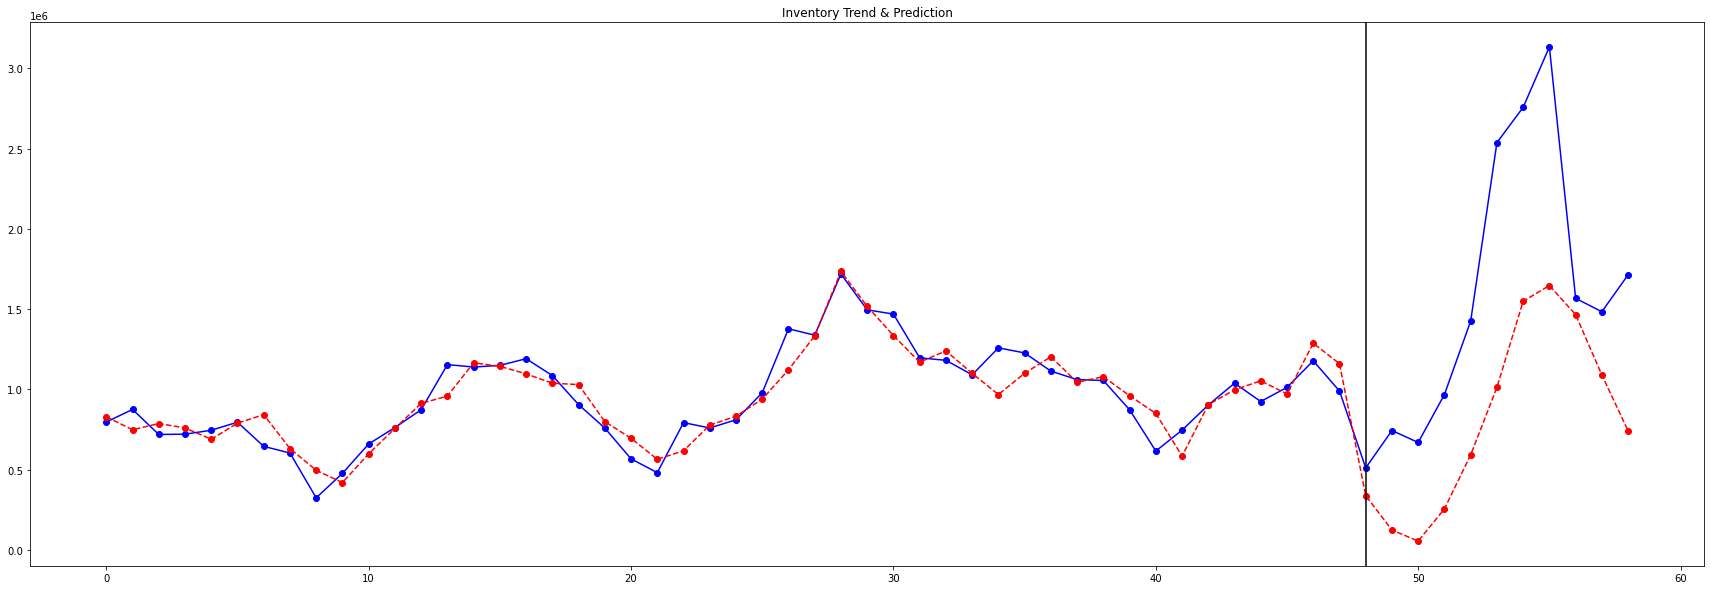

In [208]:
####################################################################################################################################
#####    |  target   |   alpha   |   m_lr    | m_max_... | m_n_es... | m_subs... |  p_col_k  |  s_col_k  |  t_col_k  |
#####    |  87.56    |  0.8896   |  0.83     |  3.115    |  28.06    |  0.6388   |  1.624    |  7.05     |  4.03     |   => XGboost
#####    |  80.79    |  0.9268   |  0.06042  |  6.205    |  24.11    |  0.6784   |  3.994    |  7.688    |  5.066    |
p_alpha = round(0.8896, 3)
p_est = round(28.06)
p_lr=round(0.83,2)
p_sub = round(0.6388,2)
p_max = round(3.115)
p_col1, s_col2, t_col3 = round(1.624), round(7.05), round(4.03)
    
weight_mat = list(map(lambda x : p_alpha**x if x > 0 else 1, range(0,12)))    
#model_=xgboost.XGBRegressor(n_estimators=p_est, learning_rate=p_lr, subsample=p_sub, max_depth=p_max, tree_method='gpu_hist', gpu_id=0)
model_ = Ridge()#KR(p_alpha)
inven_acc_, inven_acc_hat_, inven_, inven_hat_, inven_test_, inven_test_hat_ =  run_model_1(model_, d_set1, weight_mat, 
                                                                                            round(t_col3), round(s_col2), round(p_col1), 
                                                                                            202003, 202051, 202102, 202112)# # prev :/ var : 
    
plt.figure(figsize=(30,10))
plt.title("Inventory Trend & Prediction")
print(inven_acc_, inven_acc_hat_)

plt.plot(inven_, color='blue', marker='o')
plt.plot(inven_hat_, color='red', linestyle='dashed', marker='o')
plt.axvline(len(inven_test_), c='k')
